In [7]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_dwell_time_data(start_date, num_days, noise_level=0.2):
    """
    Generate synthetic canteen dwell time data for multiple stores.
    
    Parameters:
    - start_date: datetime object for the start date
    - num_days: number of days to generate data for
    - noise_level: amount of random variation (0-1)
    
    Returns:
    - DataFrame with timestamp, store, and dwell_time columns
    """
    # Store types
    stores = ['Chicken Rice', 'Indian', 'Taiwanese']
    
    # Base parameters
    hours_per_day = 10  # 10am to 7pm = 10 hours
    readings_per_hour = 60  # 1-minute intervals
    
    # Create timestamp range
    timestamps = []
    current_date = start_date
    for day in range(num_days):
        for hour in range(10, 20):  # 10 AM to 7 PM
            for minute in range(60):  # 1-minute intervals
                timestamps.append(current_date.replace(hour=hour, minute=minute))
        current_date += timedelta(days=1)
    
    # Create store-specific patterns
    all_data = []
    
    for store in stores:
        # Base dwell time pattern (in minutes)
        base_pattern = []
        for _ in range(num_days):
            daily_pattern = []
            for hour in range(10, 20):
                # Store-specific patterns
                if store == 'Chicken Rice':
                    # Highest during lunch
                    if 11 <= hour < 14:
                        base_time = 25
                    else:
                        base_time = 15
                elif store == 'Indian':
                    # More consistent throughout the day
                    if 12 <= hour < 15:
                        base_time = 20
                    else:
                        base_time = 15
                else:  # Taiwanese
                    # Popular during late afternoon
                    if 15 <= hour < 18:
                        base_time = 22
                    else:
                        base_time = 15
                
                # Add the base time for each 1-minute interval
                daily_pattern.extend([base_time] * readings_per_hour)
            base_pattern.extend(daily_pattern)
        
        # Add random variation
        noise = np.random.normal(0, noise_level * np.mean(base_pattern), len(base_pattern))
        dwell_times = np.maximum(5, np.array(base_pattern) + noise)  # Ensure minimum 5 minutes
        
        # Create store-specific DataFrame
        df_store = pd.DataFrame({
            'timestamp': timestamps,
            'store': store,
            'dwell_time': dwell_times
        })
        
        # Add day of week feature for patterns
        df_store['day_of_week'] = df_store['timestamp'].dt.day_name()
        
        # Add weekly patterns
        df_store.loc[df_store['day_of_week'].isin(['Saturday', 'Sunday']), 'dwell_time'] *= 0.7  # Lower on weekends
        df_store.loc[df_store['day_of_week'] == 'Friday', 'dwell_time'] *= 1.2  # Higher on Fridays
        
        all_data.append(df_store)
    
    # Combine all store data
    df_final = pd.concat(all_data, ignore_index=True)
    
    # Convert timestamps to UTC format
    df_final['timestamp'] = df_final['timestamp'].dt.tz_localize('Asia/Singapore').dt.tz_convert('UTC').dt.strftime('%Y-%m-%dT%H:%M:00.000Z')
    
    # Drop the day_of_week column and round dwell times
    df_final = df_final.drop('day_of_week', axis=1)
    df_final['dwell_time'] = df_final['dwell_time'].round().astype(int)
    
    # Sort by timestamp
    df_final = df_final.sort_values('timestamp')
    
    return df_final

# Example usage
if __name__ == "__main__":
    # Start from current date
    start_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    num_days = 30  # Generate 30 days of data
    
    df = generate_dwell_time_data(start_date, num_days)
    
    # Save to CSV
    df.to_csv('synthetic_dwell_times.csv', index=False)
    
    # Print some statistics
    print("\nDataset Statistics:")
    print(f"Total records: {len(df)}")
    print("\nDwell Time Statistics by Store:")
    print(df.groupby('store')['dwell_time'].describe())
    print("\nSample of the data:")
    print(df.head())


Dataset Statistics:
Total records: 54000

Dwell Time Statistics by Store:
                count       mean       std  min   25%   50%   75%   max
store                                                                  
Chicken Rice  18000.0  16.879222  6.296768  4.0  12.0  16.0  21.0  43.0
Indian        18000.0  15.482444  4.699814  4.0  12.0  15.0  19.0  35.0
Taiwanese     18000.0  16.036389  5.339474  4.0  12.0  15.0  19.0  38.0

Sample of the data:
                      timestamp         store  dwell_time
0      2024-12-22T02:00:00.000Z  Chicken Rice           6
18000  2024-12-22T02:00:00.000Z        Indian          10
36000  2024-12-22T02:00:00.000Z     Taiwanese          11
1      2024-12-22T02:01:00.000Z  Chicken Rice          11
18001  2024-12-22T02:01:00.000Z        Indian          10


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_sequences(data, seq_length):
    """Create sequences for LSTM"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

def prepare_lstm_data(df, store_name, seq_length=30):
    """Prepare data for LSTM model"""
    # Filter store data
    store_data = df[df['store'] == store_name].copy()
    
    # Convert timestamp to datetime
    store_data['timestamp'] = pd.to_datetime(store_data['timestamp'])
    
    # Create time features
    store_data['hour'] = store_data['timestamp'].dt.hour
    store_data['minute'] = store_data['timestamp'].dt.minute
    store_data['day_of_week'] = store_data['timestamp'].dt.dayofweek
    
    # Create cyclical time features
    store_data['hour_sin'] = np.sin(2 * np.pi * store_data['hour']/24)
    store_data['hour_cos'] = np.cos(2 * np.pi * store_data['hour']/24)
    store_data['minute_sin'] = np.sin(2 * np.pi * store_data['minute']/60)
    store_data['minute_cos'] = np.cos(2 * np.pi * store_data['minute']/60)
    
    # One-hot encode day of week
    dow_dummies = pd.get_dummies(store_data['day_of_week'], prefix='dow')
    store_data = pd.concat([store_data, dow_dummies], axis=1)
    
    # Select features
    feature_columns = ['dwell_time', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'] + \
                     [col for col in store_data.columns if col.startswith('dow_')]
    
    # Scale the features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(store_data[feature_columns])
    
    # Create sequences
    X, y = create_sequences(scaled_data, seq_length)
    
    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return (X_train, y_train), (X_test, y_test), scaler

def build_lstm_model(input_shape):
    """Build LSTM model"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

def train_and_predict(df, store_name):
    """Train LSTM model and make predictions"""
    # Prepare data
    (X_train, y_train), (X_test, y_test), scaler = prepare_lstm_data(df, store_name)
    
    # Build and train model
    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Inverse transform predictions to original scale
    # Create dummy array with same shape as feature set
    dummy = np.zeros((len(predictions), scaler.scale_.shape[0]))
    dummy[:, 0] = predictions.flatten()
    predictions_unscaled = scaler.inverse_transform(dummy)[:, 0]
    
    # Inverse transform actual values
    dummy = np.zeros((len(y_test), scaler.scale_.shape[0]))
    dummy[:, 0] = y_test[:, 0]
    actual_unscaled = scaler.inverse_transform(dummy)[:, 0]
    
    # Calculate metrics
    mae = np.mean(np.abs(predictions_unscaled - actual_unscaled))
    rmse = np.sqrt(np.mean((predictions_unscaled - actual_unscaled)**2))
    
    print(f"\nMetrics for {store_name}:")
    print(f"MAE: {mae:.2f} minutes")
    print(f"RMSE: {rmse:.2f} minutes")
    
    return predictions_unscaled, actual_unscaled, history

# Example usage:
if __name__ == "__main__":
    # Read data
    df = pd.read_csv('synthetic_dwell_times.csv')
    
    # Train and predict for each store
    stores = ['Chicken Rice', 'Indian', 'Taiwanese']
    results = {}
    
    for store in stores:
        predictions, actuals, history = train_and_predict(df, store)
        results[store] = {
            'predictions': predictions,
            'actuals': actuals,
            'history': history
        }

Epoch 1/50


/Users/phonavitra/Desktop/WTH2024/HotHawkersInYourArea/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1487 - mae: 0.3261 - val_loss: 0.1410 - val_mae: 0.3229
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3253 - val_loss: 0.1410 - val_mae: 0.3232
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1419 - mae: 0.3250 - val_loss: 0.1410 - val_mae: 0.3224
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1418 - mae: 0.3246 - val_loss: 0.1409 - val_mae: 0.3223
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1417 - mae: 0.3246 - val_loss: 0.1410 - val_mae: 0.3222
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1418 - mae: 0.3246 - val_loss: 0.1409 - val_mae: 0.3218
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1419 - mae: 0.3248 - val_loss: 0.1409 - val_mae: 0.3227
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1417 - mae: 0.3243 - val_loss: 0.1409 - val_mae: 0.3234
Epoch 9/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss

/Users/phonavitra/Desktop/WTH2024/HotHawkersInYourArea/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1454 - mae: 0.3273 - val_loss: 0.1417 - val_mae: 0.3221
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1426 - mae: 0.3268 - val_loss: 0.1419 - val_mae: 0.3200
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1421 - mae: 0.3267 - val_loss: 0.1417 - val_mae: 0.3218
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1422 - mae: 0.3268 - val_loss: 0.1415 - val_mae: 0.3229
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1422 - mae: 0.3269 - val_loss: 0.1415 - val_mae: 0.3233
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1421 - mae: 0.3268 - val_loss: 0.1416 - val_mae: 0.3220
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1419 - mae: 0.3261 - val_loss: 0.1415 - val_mae: 0.3229
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1420 - mae: 0.3265 - val_loss: 0.1418 - val_mae: 0.3204
Epoch 9/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss

/Users/phonavitra/Desktop/WTH2024/HotHawkersInYourArea/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1489 - mae: 0.3276 - val_loss: 0.1422 - val_mae: 0.3226
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1434 - mae: 0.3281 - val_loss: 0.1422 - val_mae: 0.3229
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3263 - val_loss: 0.1421 - val_mae: 0.3252
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3268 - val_loss: 0.1421 - val_mae: 0.3234
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1422 - mae: 0.3267 - val_loss: 0.1420 - val_mae: 0.3251
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1422 - mae: 0.3268 - val_loss: 0.1421 - val_mae: 0.3245
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1421 - mae: 0.3268 - val_loss: 0.1420 - val_mae: 0.3244
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1420 - mae: 0.3265 - val_loss: 0.1421 - val_mae: 0.3243
Epoch 9/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss

KeyboardInterrupt: 


Training model for Chicken Rice...
Epoch 1/10


/Users/phonavitra/Desktop/WTH2024/HotHawkersInYourArea/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1503 - mae: 0.3248 - val_loss: 0.1413 - val_mae: 0.3188
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3250 - val_loss: 0.1410 - val_mae: 0.3212
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1420 - mae: 0.3247 - val_loss: 0.1412 - val_mae: 0.3198
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1419 - mae: 0.3249 - val_loss: 0.1410 - val_mae: 0.3219
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1419 - mae: 0.3248 - val_loss: 0.1411 - val_mae: 0.3201
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1419 - mae: 0.3251 - val_loss: 0.1410 - val_mae: 0.3209
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1422 - mae: 0.3253 - val_loss: 0.1409 - val_mae: 0.3211
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1416 - mae: 0.3245 - val_loss: 0.1409 - val_mae: 0.3224
Epoch 9/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss

/Users/phonavitra/Desktop/WTH2024/HotHawkersInYourArea/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1495 - mae: 0.3282 - val_loss: 0.1415 - val_mae: 0.3257
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3265 - val_loss: 0.1415 - val_mae: 0.3241
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1425 - mae: 0.3271 - val_loss: 0.1414 - val_mae: 0.3244
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3268 - val_loss: 0.1414 - val_mae: 0.3254
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1418 - mae: 0.3260 - val_loss: 0.1414 - val_mae: 0.3252
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1421 - mae: 0.3265 - val_loss: 0.1414 - val_mae: 0.3255
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1417 - mae: 0.3260 - val_loss: 0.1415 - val_mae: 0.3233
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1423 - mae: 0.3271 - val_loss: 0.1414 - val_mae: 0.3238
Epoch 9/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss

/Users/phonavitra/Desktop/WTH2024/HotHawkersInYourArea/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1487 - mae: 0.3281 - val_loss: 0.1421 - val_mae: 0.3241
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1425 - mae: 0.3267 - val_loss: 0.1420 - val_mae: 0.3245
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1427 - mae: 0.3272 - val_loss: 0.1420 - val_mae: 0.3258
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1423 - mae: 0.3269 - val_loss: 0.1420 - val_mae: 0.3262
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1426 - mae: 0.3273 - val_loss: 0.1420 - val_mae: 0.3253
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1428 - mae: 0.3278 - val_loss: 0.1419 - val_mae: 0.3266
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1424 - mae: 0.3271 - val_loss: 0.1420 - val_mae: 0.3249
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1423 - mae: 0.3267 - val_loss: 0.1419 - val_mae: 0.3259
Epoch 9/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss

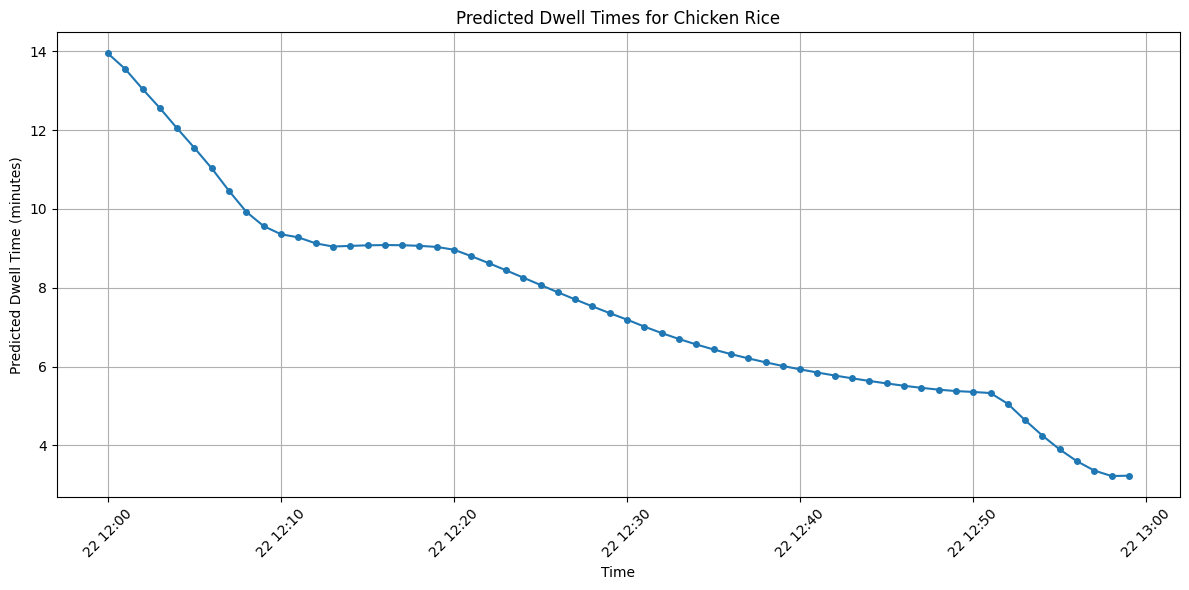


Predicted dwell times for next hour:
                  timestamp  predicted_dwell_time
0 2024-12-22 12:00:00+00:00             13.946522
1 2024-12-22 12:01:00+00:00             13.550901
2 2024-12-22 12:02:00+00:00             13.044499
3 2024-12-22 12:03:00+00:00             12.560619
4 2024-12-22 12:04:00+00:00             12.044348


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import pickle
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

class DwellTimePredictor:
    def __init__(self, save_dir='saved_models'):
        self.save_dir = save_dir
        self.trained_models = {}
        self.seq_length = 30
        
    # [Previous methods remain the same until save_models]
    
    def save_models(self):
        """Save all trained models"""
        os.makedirs(self.save_dir, exist_ok=True)
        
        for store_name, components in self.trained_models.items():
            store_dir = os.path.join(self.save_dir, store_name.replace(' ', '_'))
            os.makedirs(store_dir, exist_ok=True)
            
            # Add .keras extension for model saving
            components['model'].save(os.path.join(store_dir, 'lstm_model.keras'))
            joblib.dump(components['scaler'], os.path.join(store_dir, 'scaler.pkl'))
            components['store_data'].to_pickle(os.path.join(store_dir, 'store_data.pkl'))
            with open(os.path.join(store_dir, 'history.pkl'), 'wb') as f:
                pickle.dump(components['history'].history, f)
        
        print(f"Models saved to {self.save_dir}")
    
    def load_models(self):
        """Load all saved models"""
        if not os.path.exists(self.save_dir):
            raise FileNotFoundError(f"Directory {self.save_dir} not found")
        
        store_dirs = [d for d in os.listdir(self.save_dir) 
                     if os.path.isdir(os.path.join(self.save_dir, d))]
        
        for store_dir in store_dirs:
            store_path = os.path.join(self.save_dir, store_dir)
            store_name = store_dir.replace('_', ' ')
            
            # Load model with .keras extension
            model = load_model(os.path.join(store_path, 'lstm_model.keras'))
            scaler = joblib.load(os.path.join(store_path, 'scaler.pkl'))
            store_data = pd.read_pickle(os.path.join(store_path, 'store_data.pkl'))
            
            with open(os.path.join(store_path, 'history.pkl'), 'rb') as f:
                history = pickle.load(f)
            
            class HistoryWrapper:
                def __init__(self, history_dict):
                    self.history = history_dict
            
            self.trained_models[store_name] = {
                'model': model,
                'scaler': scaler,
                'store_data': store_data,
                'history': HistoryWrapper(history)
            }
        
        print(f"Loaded models for stores: {list(self.trained_models.keys())}")
        
    def create_sequences(self, data, seq_length):
        """Create sequences for LSTM"""
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:(i + seq_length)])
            y.append(data[i + seq_length])
        return np.array(X), np.array(y)
    
    def prepare_data(self, df, store_name):
        """Prepare data for LSTM model"""
        store_data = df[df['store'] == store_name].copy()
        store_data['timestamp'] = pd.to_datetime(store_data['timestamp'])
        
        # Create features
        store_data['hour'] = store_data['timestamp'].dt.hour
        store_data['minute'] = store_data['timestamp'].dt.minute
        store_data['day_of_week'] = store_data['timestamp'].dt.dayofweek
        
        # Cyclical features
        store_data['hour_sin'] = np.sin(2 * np.pi * store_data['hour']/24)
        store_data['hour_cos'] = np.cos(2 * np.pi * store_data['hour']/24)
        store_data['minute_sin'] = np.sin(2 * np.pi * store_data['minute']/60)
        store_data['minute_cos'] = np.cos(2 * np.pi * store_data['minute']/60)
        
        # One-hot encode day of week
        dow_dummies = pd.get_dummies(store_data['day_of_week'], prefix='dow')
        store_data = pd.concat([store_data, dow_dummies], axis=1)
        
        # Select features
        feature_columns = ['dwell_time', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'] + \
                         [col for col in store_data.columns if col.startswith('dow_')]
        
        # Scale features
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(store_data[feature_columns])
        
        # Create sequences
        X, y = self.create_sequences(scaled_data, self.seq_length)
        
        # Split data
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        return (X_train, y_train), (X_test, y_test), scaler, store_data
    
    def build_model(self, input_shape):
        """Build LSTM model"""
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=input_shape),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )
        
        return model
    
    def train_store_model(self, df, store_name):
        """Train model for a specific store"""
        print(f"\nTraining model for {store_name}...")
        (X_train, y_train), (X_test, y_test), scaler, store_data = self.prepare_data(df, store_name)
        
        model = self.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        history = model.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.2,
            verbose=1
        )
        
        self.trained_models[store_name] = {
            'model': model,
            'scaler': scaler,
            'store_data': store_data,
            'history': history
        }
    
    
    def prepare_data(self, df, store_name):
        """Prepare data for LSTM model"""
        store_data = df[df['store'] == store_name].copy()
        
        # Handle timezone conversion safely
        store_data['timestamp'] = pd.to_datetime(store_data['timestamp'])
        if store_data['timestamp'].dt.tz is None:
            store_data['timestamp'] = store_data['timestamp'].dt.tz_localize('UTC')
        else:
            store_data['timestamp'] = store_data['timestamp'].dt.tz_convert('UTC')
        
        # Create features
        store_data['hour'] = store_data['timestamp'].dt.hour
        store_data['minute'] = store_data['timestamp'].dt.minute
        store_data['day_of_week'] = store_data['timestamp'].dt.dayofweek
        
        # Cyclical features
        store_data['hour_sin'] = np.sin(2 * np.pi * store_data['hour']/24)
        store_data['hour_cos'] = np.cos(2 * np.pi * store_data['hour']/24)
        store_data['minute_sin'] = np.sin(2 * np.pi * store_data['minute']/60)
        store_data['minute_cos'] = np.cos(2 * np.pi * store_data['minute']/60)
        
        # Create fixed set of day-of-week dummies
        for i in range(7):
            store_data[f'dow_{i}'] = (store_data['day_of_week'] == i).astype(int)
        
        # Select features in fixed order
        feature_columns = ['dwell_time', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'] + \
                        [f'dow_{i}' for i in range(7)]
        
        # Scale features
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(store_data[feature_columns])
        
        # Create sequences
        X, y = self.create_sequences(scaled_data, self.seq_length)
        
        # Split data
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        return (X_train, y_train), (X_test, y_test), scaler, store_data

    def predict_next_hour(self, store_name, input_timestamp):
        """Predict dwell times for next hour"""
        if store_name not in self.trained_models:
            raise ValueError(f"No trained model found for {store_name}")
            
        # Standardize timestamp timezone handling
        if isinstance(input_timestamp, str):
            input_timestamp = pd.to_datetime(input_timestamp).tz_localize('UTC')
        elif isinstance(input_timestamp, pd.Timestamp) and input_timestamp.tz is None:
            input_timestamp = input_timestamp.tz_localize('UTC')
        elif isinstance(input_timestamp, pd.Timestamp):
            input_timestamp = input_timestamp.tz_convert('UTC')
        
        components = self.trained_models[store_name]
        model = components['model']
        scaler = components['scaler']
        store_data = components['store_data'].copy()
        
        # Handle timezone conversion safely
        if store_data['timestamp'].dt.tz is None:
            store_data['timestamp'] = store_data['timestamp'].dt.tz_localize('UTC')
        else:
            store_data['timestamp'] = store_data['timestamp'].dt.tz_convert('UTC')
        
        # Generate future timestamps
        future_timestamps = [input_timestamp + pd.Timedelta(minutes=i) for i in range(60)]
        
        # Create prediction DataFrame
        pred_df = pd.DataFrame({'timestamp': future_timestamps})
        pred_df['hour'] = pred_df['timestamp'].dt.hour
        pred_df['minute'] = pred_df['timestamp'].dt.minute
        pred_df['day_of_week'] = pred_df['timestamp'].dt.dayofweek
        
        # Create cyclical features
        pred_df['hour_sin'] = np.sin(2 * np.pi * pred_df['hour']/24)
        pred_df['hour_cos'] = np.cos(2 * np.pi * pred_df['hour']/24)
        pred_df['minute_sin'] = np.sin(2 * np.pi * pred_df['minute']/60)
        pred_df['minute_cos'] = np.cos(2 * np.pi * pred_df['minute']/60)
        
        # Create fixed set of day-of-week dummies
        for i in range(7):
            pred_df[f'dow_{i}'] = (pred_df['day_of_week'] == i).astype(int)
        
        # Get recent data for sequence
        recent_data = store_data[store_data['timestamp'] < input_timestamp].tail(self.seq_length)
        
        if len(recent_data) < self.seq_length:
            raise ValueError("Not enough historical data available")
        
        # Prepare feature columns in same order as training
        feature_columns = ['dwell_time', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'] + \
                        [f'dow_{i}' for i in range(7)]
        
        # Create initial sequence
        initial_sequence = scaler.transform(recent_data[feature_columns])
        
        # Make predictions
        predictions = []
        current_sequence = initial_sequence.copy()
        
        for i in range(60):
            X = current_sequence.reshape(1, self.seq_length, len(feature_columns))
            pred = model.predict(X, verbose=0)
            predictions.append(pred[0][0])
            
            next_features = np.zeros(len(feature_columns))
            next_features[0] = pred[0][0]
            next_features[1:5] = [
                pred_df.iloc[i]['hour_sin'],
                pred_df.iloc[i]['hour_cos'],
                pred_df.iloc[i]['minute_sin'],
                pred_df.iloc[i]['minute_cos']
            ]
            for j in range(7):
                next_features[5+j] = pred_df.iloc[i][f'dow_{j}']
            
            current_sequence = np.vstack([current_sequence[1:], next_features])
        
        # Scale back predictions
        dummy = np.zeros((len(predictions), scaler.scale_.shape[0]))
        dummy[:, 0] = predictions
        predictions_unscaled = scaler.inverse_transform(dummy)[:, 0]
        
        # Create results DataFrame
        results = pd.DataFrame({
            'timestamp': future_timestamps,
            'predicted_dwell_time': predictions_unscaled
        })
    
        return results
    
    def plot_predictions(self, predictions_df, store_name):
        """Plot predicted dwell times"""
        plt.figure(figsize=(12, 6))
        plt.plot(predictions_df['timestamp'], predictions_df['predicted_dwell_time'], 
                 marker='o', linestyle='-', markersize=4)
        plt.title(f"Predicted Dwell Times for {store_name}")
        plt.xlabel("Time")
        plt.ylabel("Predicted Dwell Time (minutes)")
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    # Initialize predictor
    predictor = DwellTimePredictor()
    
    # If training new models:
    df = pd.read_csv('synthetic_dwell_times.csv')
    stores = ['Chicken Rice', 'Indian', 'Taiwanese']
    
    for store in stores:
        predictor.train_store_model(df, store)
    
    # Save models
    predictor.save_models()
    
    # Later, to load models and make predictions:
    predictor.load_models()
    
    # Make prediction for specific time
    timestamp = "2024-12-22 12:00:00"
    store_name = "Chicken Rice"
    
    predictions = predictor.predict_next_hour(store_name, timestamp)
    predictor.plot_predictions(predictions, store_name)
    print("\nPredicted dwell times for next hour:")
    print(predictions.head())